# DBSCAN

Author: Luke Moraglia

This notebook gives an overview of the Density-Based Spatial Clustering of Applications with Noise (DBSCAN) algorithm and implements a `DBSCAN` from `scikit-learn`.

## Main idea
DBSCAN is an unsupervised clustering algorithm that identifies clusters as groups of observations with high density separated by areas of low density. Because clusters are identified by density, they can be any shape (for instance, a long winding S shape of continuously high density) whereas an algorithm like K-means tends to find clusters that are convex. DBSCAN works by identifying core samples that are close to one another (high density) and assigning them to the same cluster. Once core samples have been assigned, non-core samples are assigned to a cluster if they are close to a core sample. If a non-core sample is not close to a core sample, it is considered noise or an outlier sample and is not assigned to any cluster.

## Steps of the algorithm
1. The user must specify the maximum distance two samples can be from each other to be considered close, denoted as epsilon.
2. For each sample, identify how many other samples are within epsilon of the sample (the sample's neighbors). Samples with `min_samples` or greater neighbors are considered core samples (`min_samples` is also user defined).
3. After all core samples are identified, pick one core sample at random and assign it to the first cluster.
4. Assign all of this sample's neighbors that are also core samples to the same cluster.
5. For each neighbor that is added, repeat Step 4 until there are no more neighboring core samples. All core samples of the first cluster have now been assigned.
6. Repeat Steps 3 to 5, selecting an unassigned core sample at random to begin.
7. Once all core samples have been assigned to a cluster, for each cluster assign all non-core samples that are neighbors of at least one sample in the cluster to the cluster.
8. Non-core samples that are not the neighbor of a cluster are assigned as noise/outliers.

## Selecting epsilon and min_samples
For DBSCAN to effectively classify points, epsilon and `min_samples` need to be set well. Several rules of thumb / selection processes exist, and I have implemented some of them below.
First, `min_samples` can be selected as two times the number of features.
For epsilon, create a plot of the distances from each sample to its `min_samples`th neighbor (i.e., its furthest neighbor out of its closest `min_samples` neighbors). Where this plot's "elbow" rises steeply, the distances to the `min_samples`th neighbor are starting to increase rapidly, so this is a good spot for epsilon.

*A note of caution: the resources I found on these rules of thumb were overall lacking. The [original paper](https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf) is very difficult to understand, and several DBSCAN Python tutorials contain what appears to be a copy and pasted incorrect implementation (they plot the distances to the closest neighbor; example [here](https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc)). Ultimately, I got more confidence in the method by looking at the `dbscan` R package source code in their [`kNNdistplot`](https://github.com/mhahsler/dbscan/blob/master/R/kNNdist.R) function.*

## (Re)Sources

- [Wikipedia](https://en.wikipedia.org/wiki/DBSCAN)
- [Statquest](https://youtu.be/RDZUdRSDOok)
- [sklearn](https://scikit-learn.org/stable/modules/clustering.html#dbscan)

# Library Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.metrics as metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from helpers import cust_func

%matplotlib inline
#plt.rcParams['figure.figsize'] = [16, 9]
plt.style.use("fivethirtyeight")
%load_ext autoreload
%autoreload 2

# Load Data

For this notebook, we'll use the digits dataset. This data contains observations which are 8 by 8 pixel images of handwritten digits 0 through 9. The variables are the 64 pixel brightnesses.

In [2]:
digits = datasets.load_digits(as_frame = True)

In [3]:
X, y = digits.data, digits.target

In [4]:
X.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [5]:
y.head()

0    0
1    1
2    2
3    3
4    4
Name: target, dtype: int32

# Determining epsilon

We are going to scale our data using a `MinMaxScaler` and then reduce the dimensionality using PCA (I chose 14 components somewhat arbitrarily; they explain about 81% of the variance in the data). Because our number of features is being reduced to 14, we will choose our `min_samples` as $14 * 2 = 28$. So we will look at the distances from each point to its 28th nearest neighbor and choose an epsilon that is around the elbow of the graph.

In [6]:
n_near = 28
nn_steps = [('scaler', MinMaxScaler()), ('pca', PCA(n_components=14)), ('nn', NearestNeighbors(n_neighbors=n_near))]
nn_pipe = Pipeline(nn_steps)
nn_pipe.fit(X)

Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=14)),
                ('nn', NearestNeighbors(n_neighbors=28))])

In [7]:
distances, indices = nn_pipe['nn'].kneighbors(nn_pipe[:2].transform(X))
distances = np.sort(distances, axis=0)
#print(distances.shape)
distances = distances[:,n_near-1]

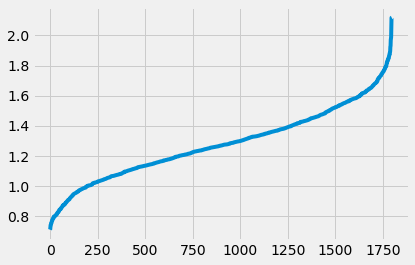

In [8]:
plt.plot(distances)

Hmmmm... There isn't a dramatic elbow, but we could guess that it is somewhere around 1.6. I can tell you that I tried this value for epsilon and it resulted in 1 cluster containing all but two of the samples. So that doesn't seem to work. What if we take the median of this graph? 

In [9]:
med = np.median(distances)
med

1.2691876874985424

We'll test that out in the next section.

# Implementing DBSCAN
We create a `Pipeline` that contains our scaling, PCA dimension reduction, and the `DBSCAN` instance with our chosen `eps` and `min_samples`. 

In [10]:
dbscan_steps = [('scaler', MinMaxScaler()), ('pca', PCA(n_components=14)), ('dbscan', DBSCAN(eps=med, min_samples=n_near))] #1.4 10 #1.05 10 #1.12 28
dbscan = Pipeline(dbscan_steps)
dbscan.fit(X) 

Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=14)),
                ('dbscan', DBSCAN(eps=1.2691876874985424, min_samples=28))])

Next we'll look at how many clusters it created, and how many samples it assigned as outliers. 

In [11]:
labels = dbscan['dbscan'].labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of outlier samples: %d" % n_noise_)

Estimated number of clusters: 6
Estimated number of outlier samples: 196


We got 6 clusters and around 200 outliers.

# Visualization
 We'll plot the samples on the first two PCA components and color them by the type of sample they were categorized as by DBSCAN.

In [12]:
classified = labels != -1
outliers = labels == -1
core = dbscan['dbscan'].core_sample_indices_
non_core = np.full(len(labels), True)
non_core[core] = False
non_core[outliers] = False

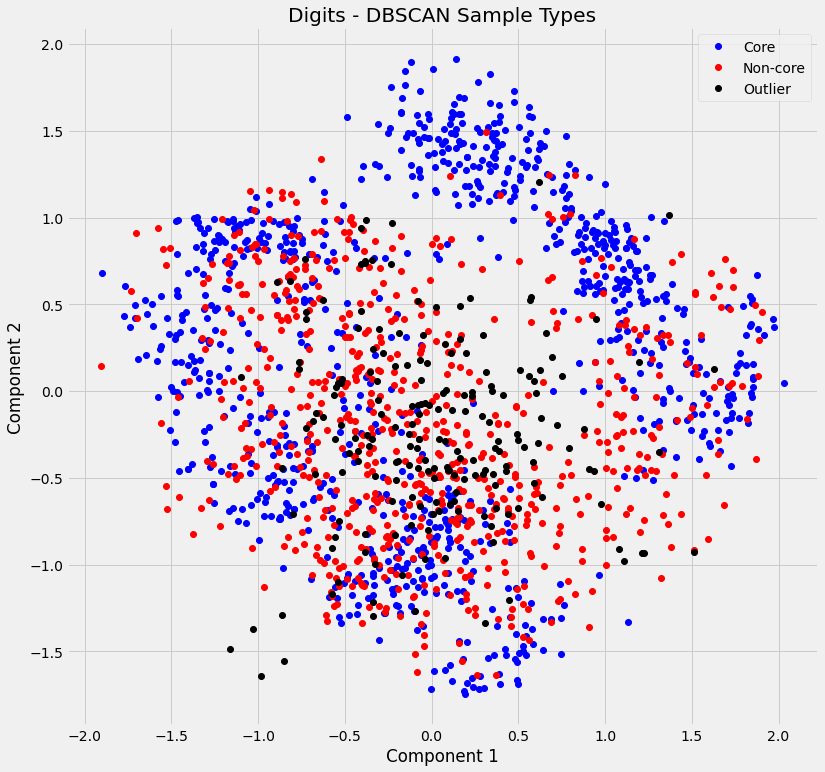

In [13]:
fscores = dbscan[:2].transform(X)
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(fscores[core, 0],
        fscores[core, 1],
        "bo",
        label="Core")
ax.plot(fscores[non_core, 0],
        fscores[non_core, 1],
        "ro",
        label="Non-core")
ax.plot(fscores[outliers, 0],
        fscores[outliers, 1],
        "ko",
        label="Outlier")
ax.set_aspect('equal')
ax.set_title("Digits - DBSCAN Sample Types")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.legend()
plt.show()

Finally, we'll plot the DBSCAN cluster assignments, and the samples labeled as outliers. Next to that graph, we will plot the true labeling of the digits.

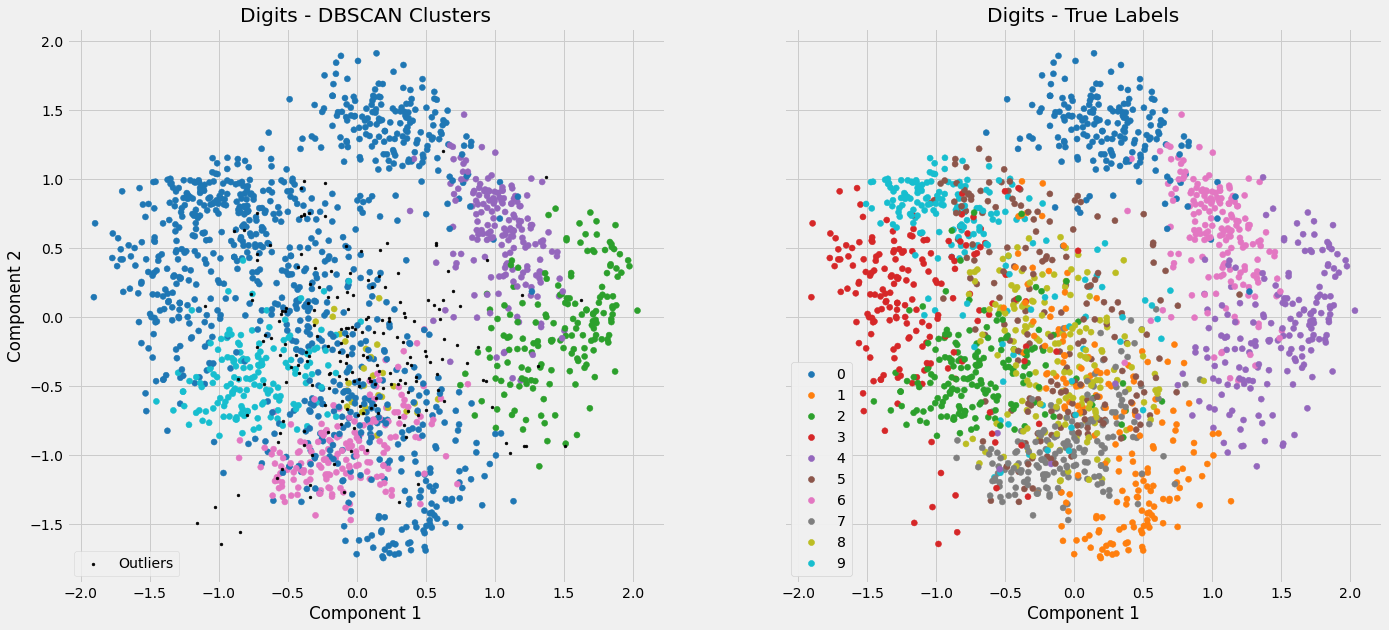

In [14]:
# Plot fscores for first two components
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (21, 12), sharey=True)
#plt.figure(figsize=(12, 12))
ax1.scatter(fscores[classified, 0], fscores[classified, 1],
            c=labels[classified], cmap=plt.cm.get_cmap('tab10', n_clusters_))
ax1.scatter(fscores[outliers, 0], fscores[outliers, 1],
            s=8,
            c="black",
            label="Outliers")
sc2 = ax2.scatter(fscores[:, 0], fscores[:, 1],
            c=y, cmap=plt.cm.get_cmap('tab10', 10),
            )

#ax = sc.axes
ax1.set_aspect('equal')
ax1.set_title("Digits - DBSCAN Clusters")
ax1.set_xlabel("Component 1")
ax1.set_ylabel("Component 2")
ax1.legend(loc="lower left")
ax2.set_aspect('equal')
ax2.set_title("Digits - True Labels")
ax2.set_xlabel("Component 1")
legend2 = ax2.legend(*sc2.legend_elements())
ax2.add_artist(legend2)

plt.show()

Several types of digits were grouped together, like 0, 9, 3, and 1.